In [1]:
import toml
import joblib
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal
from os.path import join
from tqdm.auto import tqdm
from toolz import partial
from collections import defaultdict
from tqdm.contrib.concurrent import process_map
from rl_analysis.behavior.moseq import syll_onset
from rl_analysis.io.df import NONSYLL_COLS, dlight_exclude_toml
from rl_analysis.photometry.windowing import window_trials_as_mtx
from rl_analysis.plotting import save_factory, setup_plotting_env, clean_ticks, fg

warnings.simplefilter('ignore')

In [2]:
def dlight_filter(ser):
    soscoeffs = signal.bessel(1, 1 / (30 / 2.), btype="high", output="sos")
    sig = ser.dropna()
    new_ser = pd.Series(index=ser.index)
    new_ser.loc[sig.index] = signal.sosfiltfilt(soscoeffs, sig)
    return new_ser

In [3]:
with open("../analysis_configuration.toml", "r") as f:
    config = toml.load(f)

In [4]:
setup_plotting_env()

saver = save_factory(join(config['figures']['store_dir'], 'variability-fig'), tight_layout=False)

plt.rcParams['figure.dpi'] = 300

In [5]:
use_dct = dlight_exclude_toml(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.toml'),
    **config["dlight_common"]
)

In [6]:
df = pd.read_parquet(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.parquet'),
    filters=[("uuid", "in", list(use_dct)), ("area", "=", "dls")],
)

df = df[~df["session_number"].isin([3, 4])]
df = df.drop(columns=NONSYLL_COLS)
df = df.sort_index()

df["offline onset"] = False
df.loc[df.index[syll_onset(df["predicted_syllable (offline)"])], "offline onset"] = True
df["dlight filtered"] = df.groupby("uuid", sort=False, observed=True)[
    "signal_reref_dff_z"
].transform(dlight_filter)

In [7]:
sorting = joblib.load(join(config['intermediate_results']['dlight'], 'fig1-syllable-sorting.p'))

In [8]:
time_window = (-1.5, 1.5)

# Z-scored dF/F0

In [9]:
def compute_mouse_waveforms(df, dlight_key, shuffle=False):
    out = {}
    for mouse, mouse_df in df.groupby("mouse_id", observed=True, sort=False):
        inds = np.where(mouse_df["offline onset"])[0]
        if shuffle:
            inds = inds + np.array(list(map(lambda v: random.randint(-60, 60), range(len(inds)))))
        time, trials = window_trials_as_mtx(
            mouse_df, inds, dlight_key, truncation_window=time_window, zscore_signal=True
        )
        out[mouse] = pd.Series(np.nanmean(trials, axis=0), index=pd.Index(time, name="time"))
    return pd.DataFrame(out)


def compute_shuffle(i, df, waveform_func, dlight_key="signal_reref_dff_z"):
    result = waveform_func(df, dlight_key, shuffle=True)
    return pd.concat({i: result}, names=["shuffle"])

In [10]:
n_shuffles = 1_000
dlight_key = "dlight filtered"

results = process_map(
    partial(
        compute_shuffle,
        df=df[["mouse_id", "uuid", dlight_key, "offline onset"]],
        waveform_func=compute_mouse_waveforms,
        dlight_key=dlight_key,
    ),
    range(n_shuffles),
    max_workers=6,
)

# SAVE SHUFFLES
joblib.dump(
    results,
    join(config["intermediate_results"]["dlight"], "figs4-filtered-mouse-waveform-shuffles.p"),
)

  0%|          | 0/1000 [00:00<?, ?it/s]

['/n/groups/datta/win/dopamine-data-release/zenodo-test/dlight_intermediate_results/figs4-filtered-mouse-waveform-shuffles.p']

In [11]:
# results = joblib.load(join(config["intermediate_results"]["dlight"], "figs4-filtered-mouse-waveform-shuffles.p"))

shuff_df = pd.concat(results)

In [12]:
mean_df = compute_mouse_waveforms(df, dlight_key)
z_df = (mean_df - shuff_df.groupby('time').mean()) / shuff_df.groupby('time').std()

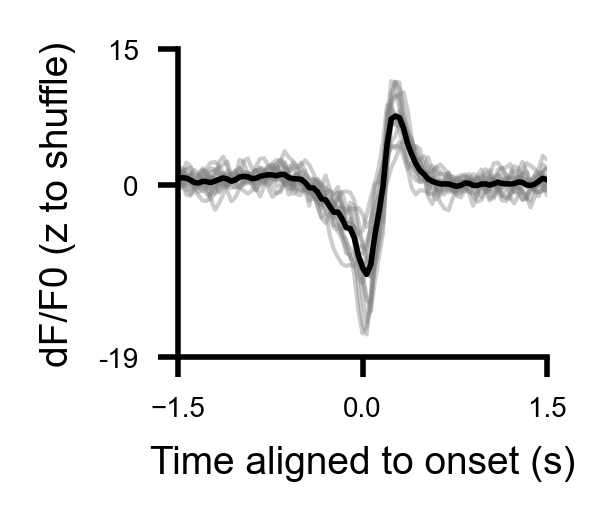

In [13]:
fig = fg(1.19, 1)
fig.dpi = 200
ax = fig.gca()
for k, v in z_df.items():
    ax.plot(v.index, v, lw=0.75, c="gray", alpha=0.4)
ax.plot(z_df.mean(1), c='k', lw=1)
ax.set(
    xlim=time_window,
    xlabel="Time aligned to onset (s)",
    ylabel="dF/F0 (z to shuffle)",
    xticks=(time_window[0], 0, time_window[1]),
    ylim=(-19, 15),
)
clean_ticks(ax, axis="y", zero_symmetry=False, dtype=int)
sns.despine()
saver(fig, "filtered-grand-average-per-mouse-z");

## Plot grand average waveforms per session

In [14]:
def compute_session_waveforms(df, dlight_key, shuffle=False):
    out = {}
    for uuid, uuid_df in df.groupby("uuid", observed=True, sort=False):
        inds = np.where(uuid_df["offline onset"])[0]
        if shuffle:
            inds = inds + np.array(list(map(lambda v: random.randint(-60, 60), range(len(inds)))))
        time, trials = window_trials_as_mtx(
            uuid_df, inds, dlight_key, truncation_window=time_window, zscore_signal=True
        )
        out[uuid] = pd.Series(np.nanmean(trials, axis=0), index=pd.Index(time, name='time'))
    return pd.DataFrame(out)

In [15]:
n_shuffles = 1_000
dlight_key = "dlight filtered"

results = process_map(
    partial(
        compute_shuffle,
        df=df[["mouse_id", "uuid", dlight_key, "offline onset"]],
        waveform_func=compute_session_waveforms,
        dlight_key=dlight_key,
    ),
    range(n_shuffles),
    max_workers=6,
)

# SAVE SHUFFLES
joblib.dump(
    results,
    join(config["intermediate_results"]["dlight"], "figs4-filtered-session-waveform-shuffles.p"),
)

  0%|          | 0/1000 [00:00<?, ?it/s]

['/n/groups/datta/win/dopamine-data-release/zenodo-test/dlight_intermediate_results/figs4-filtered-session-waveform-shuffles.p']

In [16]:
# results = joblib.load(join(config["intermediate_results"]["dlight"], "figs4-filtered-session-waveform-shuffles.p"))

shuff_df = pd.concat(results)

In [17]:
session_data = {}
boundaries = defaultdict(lambda: 0)
for (mouse, uuid), mouse_df in tqdm(df.groupby(["mouse_id", "uuid"], observed=True)):
    inds = np.where(mouse_df["offline onset"])[0]
    time, trials = window_trials_as_mtx(
        mouse_df, inds, dlight_key, zscore_signal=True, truncation_window=time_window
    )
    session_data[uuid] = np.nanmean(trials, axis=0)
    boundaries[mouse] += 1

session_data = pd.DataFrame(session_data, index=time)

gb = shuff_df.groupby('time')
z_sessions = (session_data - gb.mean()) / gb.std()

  0%|          | 0/216 [00:00<?, ?it/s]

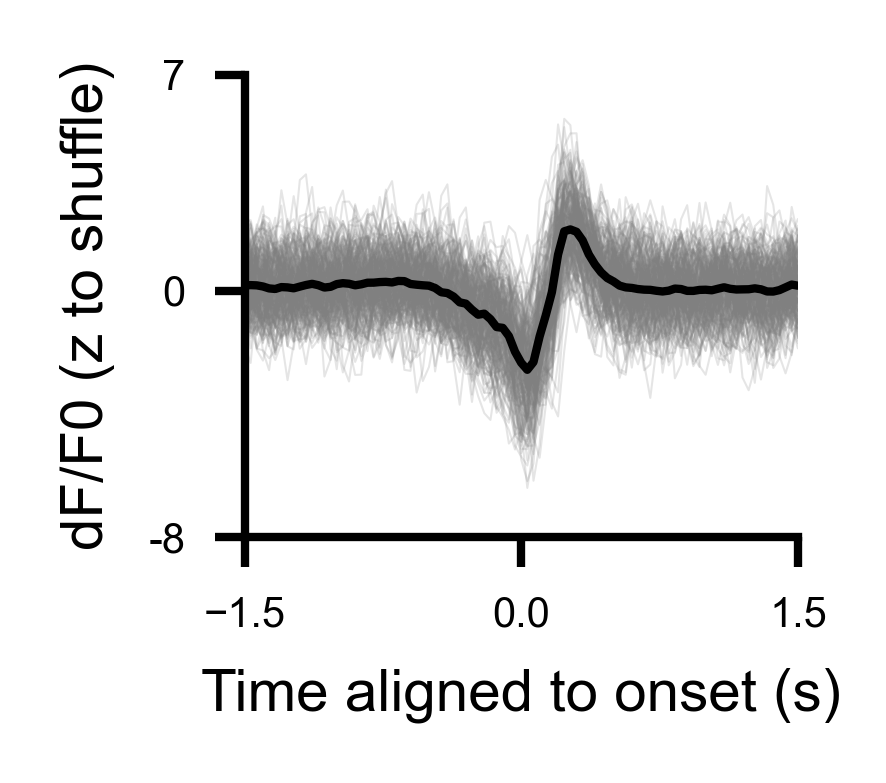

In [18]:
fig = fg(1.19, 1)
fig.dpi = 300
ax = fig.gca()
for k, v in z_sessions.items():
    ax.plot(v, lw=0.25, c="gray", alpha=0.2)
ax.plot(z_sessions.mean(1), lw=1, c="k")
ax.set(
    xlim=time_window,
    xlabel="Time aligned to onset (s)",
    ylabel="dF/F0 (z to shuffle)",
    xticks=(time_window[0], 0, time_window[1]),
    ylim=(-8, 7),
)
clean_ticks(ax, axis="y", zero_symmetry=False, dtype=int)
sns.despine()
saver(fig, "filtered-grand-average-per-session-z");

## Plot heatmap of mouse dLight waveforms

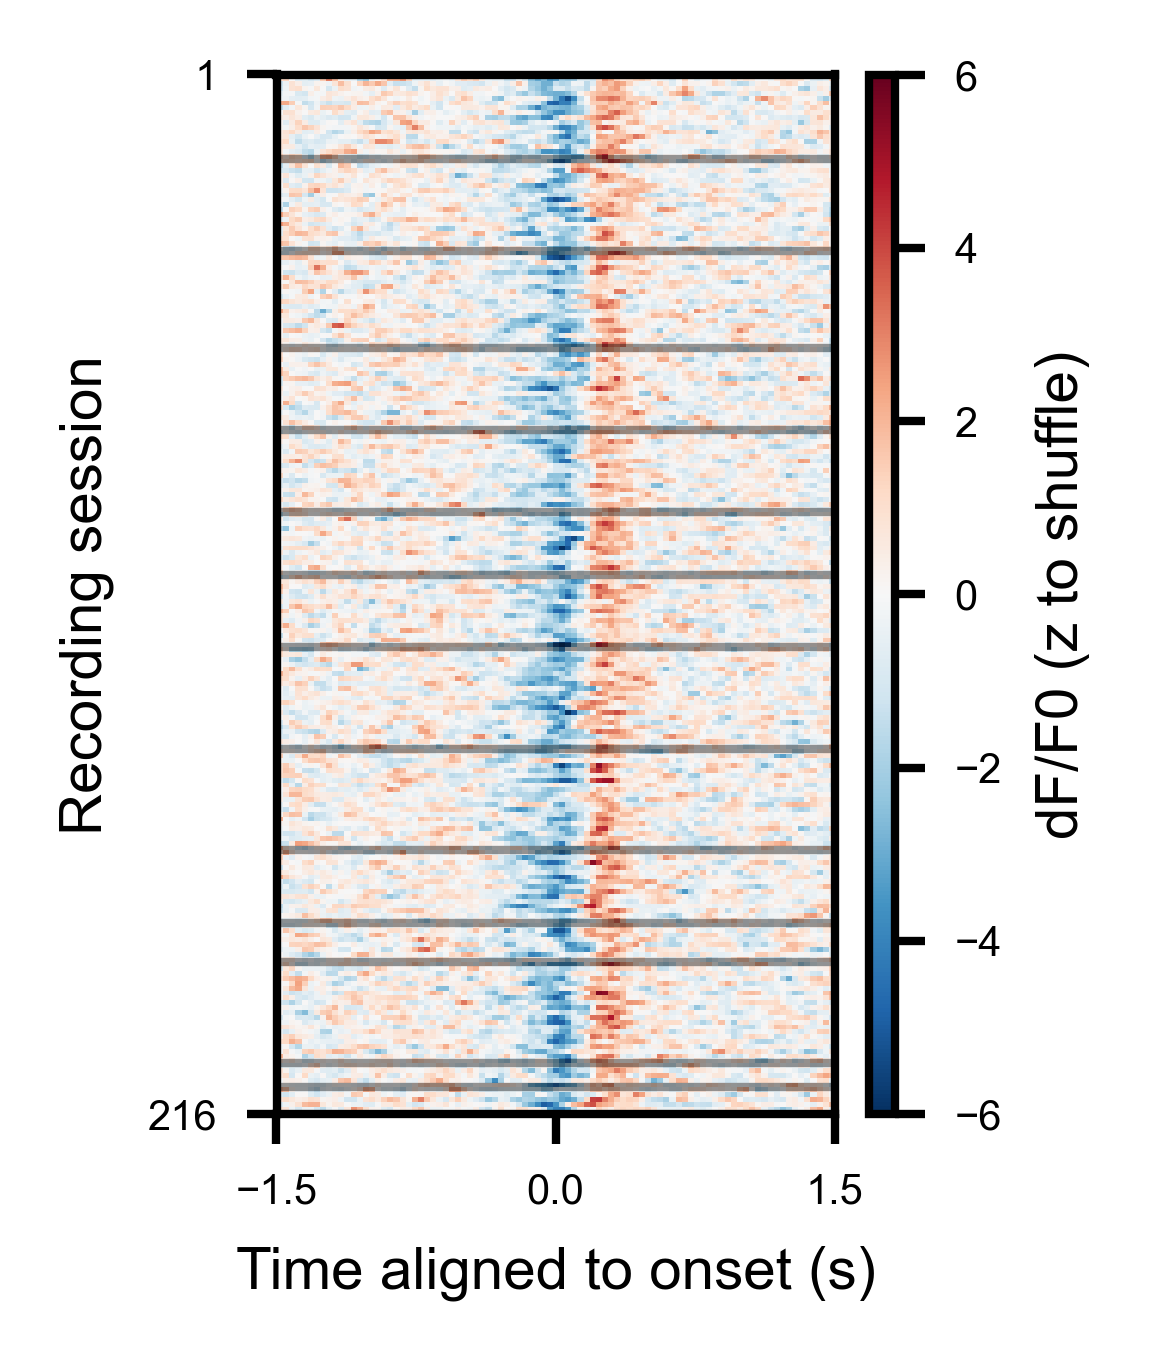

In [19]:
fig = fg(1.5, 2.25)
fig.dpi = 300
ax = fig.gca()
im = ax.imshow(
    z_sessions.T,
    cmap="RdBu_r",
    vmin=-6,
    vmax=6,
    aspect="auto",
    interpolation="none",
    extent=(time[0], time[-1], len(z_sessions.T), 0),
)
for v in np.cumsum(list(boundaries.values())):
    ax.axhline(v, color='k', linestyle='-', lw=1, alpha=0.4)
ax.set(
    xticks=[time_window[0], 0, time_window[1]],
    xlim=time_window,
    yticks=[0.5, len(z_sessions.T) - 0.5],
    yticklabels=[1, len(z_sessions.T)],
    ylabel="Recording session",
    xlabel="Time aligned to onset (s)",
    ylim=(len(z_sessions.T) - 0.5, 0.5),
)
fig.colorbar(im, ax=ax, label="dF/F0 (z to shuffle)", aspect=40)
saver(fig, 'filtered-dlight-aligned-per-session-z');